## In this lab, the idea is to download a public dataset, make a transformation (agregate, join and filter data to create a new table), convert the files to optimized formats, and then record everything in our data lake:

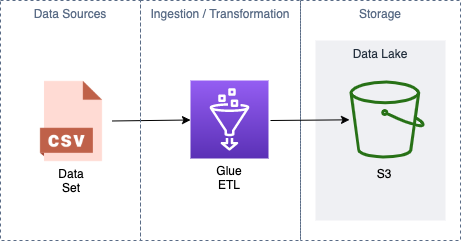

## 1) Install required packages

In [ ]:
!pip install pandas
!pip install pyarrow
!pip install s3fs
!pip install simplejson

## 2) Import packages

In [ ]:
import urllib.request
from zipfile import ZipFile
import pandas as pd
import os

## 3) Retrieve your account number and set a bucket name

In [ ]:
import simplejson
with open('/opt/ml/metadata/resource-metadata.json') as fh:
    metadata = simplejson.loads(fh.read())
accountid = metadata['ResourceArn'].split(':')[4]

%set_env accountid={accountid}
%set_env bucket_name=lab-{accountid}

## 4) Download MovieLens 1M Dataset

In [ ]:
print("downloading file from movielens website...")
urllib.request.urlretrieve(
        'http://files.grouplens.org/datasets/movielens/ml-1m.zip',
        '/tmp/ml-1m.zip')

## 5) Extract the zip file

In [ ]:
print("extracting dataset into tmp folder...")
with ZipFile('/tmp/ml-1m.zip', 'r') as zipObj:
   zipObj.extractall('/tmp/')

## 6) Ingesting RAW data

In [ ]:
import datetime

x = datetime.datetime.now()
etl_date = x.strftime("%Y%m%d_%H%M%S")
print(etl_date) 
%set_env etl_date={etl_date}

In [ ]:
%%bash
aws s3 cp /tmp/ml-1m/movies.dat s3://$bucket_name/data/landing/movies/movies_$etl_date.dat
aws s3 cp /tmp/ml-1m/ratings.dat s3://$bucket_name/data/landing/ratings/ratings_$etl_date.dat

## 7) Read the CSV

In [ ]:
print("reading csv files...")
movies_df = pd.read_csv("/tmp/ml-1m/movies.dat", "::", 
                        engine='python', 
                        header=None, 
                        names=['movieid', 'title', 'genres']) 
print("movies_df has %s lines" % movies_df.shape[0])

In [ ]:
ratings_df = pd.read_csv("/tmp/ml-1m/ratings.dat", "::", 
                         engine='python', 
                         header=None, 
                         names=['userid', 'movieid', 'rating', 'timestamp']) 
print("ratings_df has %s lines" % ratings_df.shape[0])

In [ ]:
movies_df[0:5]

In [ ]:
ratings_df[0:5]

## 8) Join both dataframes

In [ ]:
print("merging dataframes...")
merged_df = pd.merge(movies_df, ratings_df, on='movieid')

## 9) Aggregate data from dataframes, counting votes...

In [ ]:
print("aggregating data...")
aggregation_df = merged_df.groupby('title').agg({'rating': ['count', 'mean']})
aggregation_df.columns = aggregation_df.columns.droplevel(level=0)
aggregation_df = aggregation_df.rename(columns={
    "count": "rating_count", "mean": "rating_mean"
})

## 10) Sorting data and filtering only movies with more than 1000 votes...

In [ ]:
print("sorting data...")
aggregation_df = aggregation_df.sort_values(
        'rating_mean', 
        ascending=False).loc[aggregation_df['rating_count'] > 1000].head()

## 11) Writing files to s3...

In [ ]:
print("writing files to s3...")

movies_df.to_parquet(
        "s3://" + 
        os.getenv('bucket_name') + 
        "/data/analytics/movies/movies_" + 
        etl_date + 
        ".parquet.snappy")

ratings_df.to_parquet(
        "s3://" + 
        os.getenv('bucket_name') + 
        "/data/analytics/ratings/ratings_" +
        etl_date + 
        ".parquet.snappy")

aggregation_df.to_parquet(
        "s3://" + 
        os.getenv('bucket_name') + 
        "/data/analytics/best_movies/best_movies_" +
        etl_date + 
        ".parquet.snappy")

## 12) Reading data...

In [ ]:
print("reading file from s3 and printing result...")
result_df = pd.read_parquet(
        "s3://" + 
        os.getenv('bucket_name') + 
        "/data/analytics/best_movies/best_movies_" + etl_date + ".parquet.snappy")
print("result_df has %s lines" % result_df.size)

In [ ]:
print("Top 5 movies: ")
result_df[0:5]